<a href="https://colab.research.google.com/github/kaiser1711/Subnanosecond-Fluctuations-in-Low-Barrier-Nanomagnets/blob/main/Fluctuations_in_LBMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from numba import njit
from scipy import constants as constants; from scipy import signal as sig
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context("poster")

In [2]:
#mx=sin(theta) cos(phi)
#my=sin(theta) sin(phi)
#mz=cos(theta)

@njit #nopython compiler for faster execution time
def llg_dt(v,alpha,hk,hp,hx,hy,hz):
  theta=v[0]
  phi=v[1]
  dtheta_hk_z=hk*(-alpha*np.sin(theta)*np.cos(theta)) #uniaxial anisotropy in z-direction 
  dtheta_hp_x=-hp*(-np.sin(phi)+alpha*np.cos(theta)*np.cos(phi))*np.sin(theta)*np.cos(phi) #demagnetization field in x-axis (Note: this is different as in the PRApplied paper where the demag. field on the z-axis)
  dtheta_ex=alpha*np.cos(theta)*np.sin(phi)*hy+np.cos(phi)*hy-np.sin(phi)*hx-alpha*np.sin(theta)*hz+alpha*np.cos(theta)*np.cos(phi)*hx #external field

  dphi_hk_z=np.cos(theta) #uniaxial anisotropy in z-direction
  dphi_hp_x=hp*(np.cos(phi)**2*np.cos(theta)+alpha*np.cos(phi)*np.sin(phi)) #demagnetization field in x-axis
  dphi_ex=hz+(-alpha*hx*np.sin(phi)-hx*np.cos(theta)*np.cos(phi))/np.sin(theta)+(alpha*hy*np.cos(phi)-hy*np.cos(theta)*np.sin(phi))/np.sin(theta) #external field

  dtheta=(gamma/(1+alpha**2))*(dtheta_hk_z+dtheta_hp_x+dtheta_ex)
  dphi=(gamma/(1+alpha**2))*(dphi_hk_z+dphi_hp_x+dphi_ex)
  return np.array([dtheta,dphi])

@njit
def timestep(theta,phi,alpha,hk,hp,hx,hy,hz,dt):
  v=np.array([theta,phi])
  k1=dt*llg_dt(v,alpha,hk,hp,hx,hy,hz)
  k2=dt*llg_dt(v+k1/2,alpha,hk,hp,hx,hy,hz)
  k3=dt*llg_dt(v+k2/2,alpha,hk,hp,hx,hy,hz)
  k4=dt*llg_dt(v+k3,alpha,hk,hp,hx,hy,hz)
  v=v+(k1+2*k2+2*k3+k4)/6   #Runge-Kutta method
  theta=v[0]
  phi=v[1]
  return theta,phi

@njit
def simulate(dt,NT,Ms,Vol,alpha,gamma,theta_init,phi_init,hk,hp,hx,hy,hz):
  kB=constants.k*1e7
  theta=theta_init
  phi=phi_init
  theta_arr=np.zeros(NT,)
  phi_arr=np.zeros(NT,)
  for n in range(0,NT):
    theta,phi=timestep(theta,phi,alpha,hk,hp,hx[n],hy[n],hz[n],dt)
    theta_arr[n]=theta
    phi_arr[n]=phi
  return theta_arr,phi_arr


**Parameters** (in cgs units)

In [3]:
#material parameters
T=300 #temperature (needed for noise)
Ms=1100 #saturation magnetization
Vol=(10e-7/2)**2*np.pi*1e-7 #volume of magnet (circular shape 10nm diameter, 1nm thickness)
gamma=constants.value('electron gyromag. ratio')/1e4 #gyromagnetic ratio
kB=constants.k*1e7 # Boltzmann constant
alpha=0.01 #Gilbert damping 
hk=0    # uniaxial field
hp=4*np.pi*Ms #demag. field

#simulation parameters
NT=int(1e7)   #total timesteps
dt=1e-6/NT    #delta timestep

**External field** (here just Langevin field)

In [4]:
sigma=np.sqrt(2*alpha*kB*T/(Ms*Vol*gamma*dt))
hxL=sigma*np.random.normal(loc=0,scale=1,size=NT)
hyL=sigma*np.random.normal(loc=0,scale=1,size=NT)
hzL=sigma*np.random.normal(loc=0,scale=1,size=NT)

**Running simulation**

In [5]:
#initial conditions
theta_init=0.01
phi_init=np.pi/2

#simulation
theta_arr,phi_arr=simulate(dt,NT,Ms,Vol,alpha,gamma,theta_init,phi_init,hk,hp,hxL,hyL,hzL)

#time
time=np.linspace(0,dt*NT,NT)

**Time sequence**

Text(0, 0.5, '$m_x$')

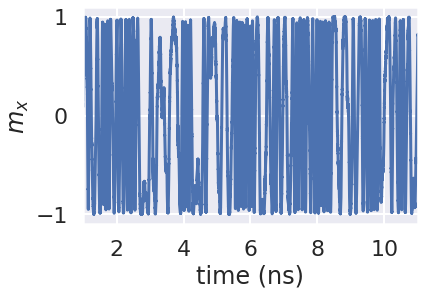

In [6]:
plt.plot(time*1e9,np.cos(theta_arr)) 
plt.xlim([1,11])
plt.xlabel('time (ns)')
plt.ylabel('$m_x$')


**Autocorrelation (Fig. 2 a):** The autocorrelation quantifies the mean reversal time of the magnet in a thermal bath.

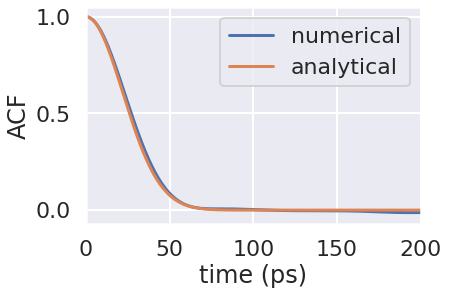

In [7]:
ctime=np.linspace(-NT*dt,NT*dt,NT*2-1)
cX=sig.fftconvolve(np.cos(theta_arr), np.flip(np.cos(theta_arr)), mode='full')

plt.plot(ctime*1e12,cX/np.max(cX),label='numerical') 
plt.plot(ctime*1e12,np.exp(-gamma**2*hp*kB*T/Ms/Vol*ctime**2/2),label='analytical') #Eqn. 7
plt.xlabel('time (ps)')
plt.ylabel('ACF')
plt.xlim([0,200])
plt.legend()

**Ensemble simulation**

In [8]:
ensemble=500

#simulation parameters
NT=int(1e5)   #total timesteps
dt=1e-9/NT    #delta timestep

#time
time=np.linspace(0,dt*NT,NT)

#initialize ensemble angles
phi_en=np.zeros((NT,ensemble))
theta_en=np.zeros((NT,ensemble))

#Langevin fields
sigma=np.sqrt(2*alpha*kB*T/(Ms*Vol*gamma*dt))
hxL=sigma*np.random.normal(loc=0,scale=1,size=(NT,ensemble))
hyL=sigma*np.random.normal(loc=0,scale=1,size=(NT,ensemble))
hzL=sigma*np.random.normal(loc=0,scale=1,size=(NT,ensemble))

#simulation for every ensemble
for ii in range(0,ensemble):
  #print(ii)
  theta_arr,phi_arr=simulate(dt,NT,Ms,Vol,alpha,gamma,theta_init,phi_init,hk,hp,hxL[:,ii],hyL[:,ii],hzL[:,ii])
  phi_en[:,ii]=phi_arr
  theta_en[:,ii]=theta_arr

**Memory loss (Fig. 3a):** Memory loss quantifies how long it takes for the magnetization to become unpredicatable.

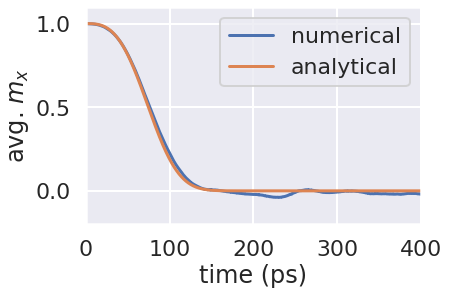

In [9]:
plt.plot(time*1e12,np.mean(np.cos(theta_en),axis=1),label='numerical') 
plt.plot(time*1e12,np.exp(-alpha*gamma**3*hp**2*kB*T/Ms/Vol*time**3/3),label='analytical') #Eqn. 12

plt.xlabel('time (ps)')
plt.ylabel('avg. $m_x$')
plt.xlim([0,400])
plt.ylim([-0.2,1.1])

plt.legend()